<a href="https://colab.research.google.com/github/CPieter/2AMM10-Assignments/blob/main/A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

In [ ]:

# function for loading the training data:

def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

train_data = load_data('data/a1/train_data.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'data/a1/train_data.pkl'

In [ ]:
# '''
# use this cell to mount your drive if you're using Google Colab
from google.colab import drive
!mkdir drive
drive.mount('drive')

train_data = load_data('drive/MyDrive/GoogleColab/2AMM10/data_A1_2AMM10_2023_2024/train_data.pkl')
data_dict_test = load_data('drive/MyDrive/GoogleColab/2AMM10/data_A1_2AMM10_2023_2024/test_data_task1.pkl')
data_dict_test_task2 = load_data('drive/MyDrive/GoogleColab/2AMM10/data_A1_2AMM10_2023_2024/test_data_task2.pkl')
# '''

mkdir: cannot create directory ‘drive’: File exists
Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.

# see the code below for examples of working with the train data

alphabets = list(train_data.keys())


print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2

print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


In [ ]:
# function for plotting some examples:

def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)

    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        print(images[im_idx].shape)
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()


torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])


<Figure size 640x480 with 0 Axes>

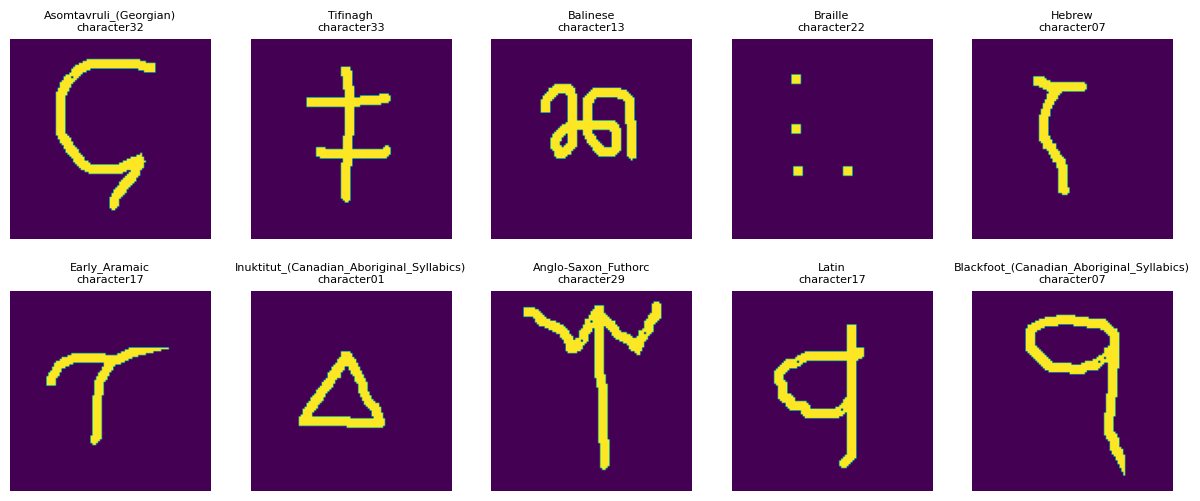

In [ ]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

# Task 1: character recognition

In [ ]:
# our solution:
import pandas as pd

# print(train_data['Alphabet_of_the_Magi']['character01'])
# print(len(train_data['Alphabet_of_the_Magi']['character01']))

df_tobe = []
for alphabet in train_data.keys():
    for key in train_data[alphabet].keys():
        for image in train_data[alphabet][key]:
            df_tobe.append((alphabet + '_' + key, image))
train_data_df = pd.DataFrame(data=df_tobe)

# train_data_df = pd.DataFrame(data=((alphabet + '_' + key, image) for image in train_data[alphabet][key] for key in train_data[alphabet].keys() for alphabet in train_data.keys()))
# print(train_data_df[0])
# print(np.array(train_data_df[1][0]).shape)

In [ ]:
print(train_data.keys())

# random seed
random_seed = 42

from sklearn.model_selection import train_test_split
# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    train_data_df[1],
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    train_data_df[0],
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# for alphabet in train_data.keys():
#     for character in train_data[alphabet].keys():
#         print(len(train_data[alphabet][character]))

dict_keys(['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh'])


In [ ]:
label_to_idx_train = {k: v for v, k in enumerate(train_data_df[0].unique())}
idx_to_label_train = {v: k for v, k in enumerate(train_data_df[0].unique())}

inputs_train = inputs_train.values
inputs_valid = inputs_valid.values

targets_train = np.array([label_to_idx_train[label] for label in targets_train])
targets_valid = np.array([label_to_idx_train[label] for label in targets_valid])

In [ ]:
# Datasets and Dataloaders
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from itertools import combinations


class CustomImageDataset(Dataset):
    def __init__(self, inputs: list, targets: list, transform=None, target_transform=None):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        self.classes = label_to_idx_train.keys()

        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index: int):

        input_id = self.inputs[index]
        target_id = self.targets[index]

        x = self.inputs[index]
        y = self.targets[index]

        # Load input and target
        #x=Image.open(input_id)
        #y=Image.open(target_id)

        # Preprocessing
        if self.transform is not None:
            x=self.transform(x).type(self.inputs_dtype)

        return x, y

class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels

        # unique_labels = np.unique(np.array(self.labels))
        # self.labels_set = unique_labels.tolist()
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size


class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

In [ ]:
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Resize

image_size_task1 = (32,32)

DATA_TRANSFORM_TASK1= transforms.Compose([
    transforms.Resize(image_size_task1),
    transforms.RandomRotation(10)
    # transforms.ToTensor(),
    ])

train_dataset_task1 = CustomImageDataset(inputs=inputs_train.copy(), targets=targets_train.copy(), transform=DATA_TRANSFORM_TASK1)
val_dataset_task1 = CustomImageDataset(inputs=inputs_valid.copy(), targets=targets_valid.copy(), transform=DATA_TRANSFORM_TASK1)

train_batch_sampler_task1 = BalancedBatchSampler(train_dataset_task1.targets, n_classes=20, n_samples=5)
test_batch_sampler_task1 = BalancedBatchSampler(val_dataset_task1.targets, n_classes=20, n_samples=5)

triplets_train_loader_task1 = torch.utils.data.DataLoader(train_dataset_task1, batch_sampler=train_batch_sampler_task1)
triplets_val_loader_task1 = torch.utils.data.DataLoader(val_dataset_task1, batch_sampler=test_batch_sampler_task1)

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class EmbeddingNet_Task1(nn.Module):
    def __init__(self, embedding_size=40):
        """CNN Builder."""
        super(EmbeddingNet_Task1, self).__init__()

        self.embedding_size = embedding_size

        self.front_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Lambda(lambda x: x.view(x.size(0), -1)),

            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        self.last_layer = nn.Linear(512, self.embedding_size)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]


        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

# Training

In [ ]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs




    def run_trainer(self):


        for epoch in tqdm(range(self.epochs)):



            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss

                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters



            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss

                    loss_value = loss.item()
                    valid_losses.append(loss_value)



            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

In [ ]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

# model
embedding_net = EmbeddingNet_Task1()
model1 = embedding_net.to(device)


# margin value
margin=1

# criterion
criterion = TripletLoss(margin,  RandomTripletSelector())

# optimizer
optimizer = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

# trainer
trainer = Trainer(model=model1,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader_task1,
                  validation_DataLoader=triplets_val_loader_task1,
                  epochs=10)

# start training
trainer.run_trainer()

 10%|█         | 1/10 [00:13<02:05, 13.92s/it]

EPOCH: 01/10 LOSS: 0.5826 VAL-LOSS: 0.3138


 20%|██        | 2/10 [00:27<01:48, 13.61s/it]

EPOCH: 02/10 LOSS: 0.2454 VAL-LOSS: 0.1950


 30%|███       | 3/10 [00:40<01:32, 13.26s/it]

EPOCH: 03/10 LOSS: 0.1700 VAL-LOSS: 0.1201


 40%|████      | 4/10 [00:53<01:18, 13.14s/it]

EPOCH: 04/10 LOSS: 0.1199 VAL-LOSS: 0.1114


 50%|█████     | 5/10 [01:05<01:05, 13.03s/it]

EPOCH: 05/10 LOSS: 0.0878 VAL-LOSS: 0.0782


 60%|██████    | 6/10 [01:19<00:52, 13.05s/it]

EPOCH: 06/10 LOSS: 0.0815 VAL-LOSS: 0.0872


 70%|███████   | 7/10 [01:31<00:38, 12.98s/it]

EPOCH: 07/10 LOSS: 0.0693 VAL-LOSS: 0.0614


 80%|████████  | 8/10 [01:44<00:25, 12.81s/it]

EPOCH: 08/10 LOSS: 0.0605 VAL-LOSS: 0.0632


 90%|█████████ | 9/10 [01:56<00:12, 12.64s/it]

EPOCH: 09/10 LOSS: 0.0539 VAL-LOSS: 0.0673


100%|██████████| 10/10 [02:08<00:00, 12.87s/it]

EPOCH: 10/10 LOSS: 0.0458 VAL-LOSS: 0.0544


In [ ]:
torch.save(model1.state_dict(), 'a1_model1.pt')

# Evaluation

In [ ]:
model1 = EmbeddingNet_Task1()
model1.load_state_dict(torch.load('a1_model1.pt'))
# model1.eval()

EmbeddingNet_Task1(
  (front_layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inpl

**ACCURACY**

In [ ]:
def extract_embeddings(dataloader, model):

    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), model.embedding_size))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.to("cuda")
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [ ]:
class CharacterMatcher:
    def __init__(self, model, transform):
        self.model = model
        if torch.cuda.is_available():
          self.model = model.to("cuda")
        self.transform = transform


    def fit(self, alphabet, alphabet_labels, char_to_type=None, type_following_probs=None):
        label_to_idx_alphabet = {label: idx for idx, label in enumerate(alphabet_labels)}
        alphabet_targets = np.array([label_to_idx_alphabet[label] for label in alphabet_labels])

        alphabet_dataset = CustomImageDataset(inputs=alphabet, targets=alphabet_targets, transform=self.transform)
        alphabet_loader = torch.utils.data.DataLoader(alphabet_dataset, batch_size=256)

        self.alphabet_embeddings, _ = extract_embeddings(alphabet_loader, self.model)
        self.labels = alphabet_labels
        self.char_to_type = char_to_type
        self.type_following_probs = type_following_probs


    def get_distance_multipliers(self, preceding_type, domain_knowledge_factor):
        types = [self.char_to_type[label] for label in self.labels]
        following_probs = [self.type_following_probs[preceding_type][following_type] for following_type in types]
        multipliers = [1 - prob for prob in following_probs]
        mult_mean = np.mean(np.array(multipliers))
        # multipliers_with_factor = [1 - domain_knowledge_factor + domain_knowledge_factor * multiplier for multiplier in multipliers]
        # multipliers_with_factor = [1 - domain_knowledge_factor * mult_mean**0.5 + domain_knowledge_factor * multiplier**0.5 for multiplier in multipliers]
        multipliers_with_factor = [1 + domain_knowledge_factor * multiplier**2 for multiplier in multipliers]
        return multipliers_with_factor


    def get_matches(self, image, k=1, preceding_type=None, domain_knowledge_factor=0):
        if len(self.labels) == 0:
            print("character matcher must be fitted before matching")
            return

        with torch.no_grad():
            if torch.cuda.is_available():
                image = image.cuda()
            self.model.eval()

            image = image[None,None,].type(torch.float32)
            if self.transform is not None:
                image = self.transform(image)

            unseen_embedding = self.model.get_embedding(image).data.cpu().numpy()

        distances = [np.linalg.norm(embedding - unseen_embedding) for embedding in self.alphabet_embeddings]

        if preceding_type is not None:
            multipliers = self.get_distance_multipliers(preceding_type, domain_knowledge_factor)
            distances = [a*b for a,b in zip(distances, multipliers)]

        distance_sort = np.argsort(distances)
        return np.array(self.labels.copy())[distance_sort][:k].tolist()

In [108]:
def get_accuracy(model, data_dict_test, k=1, transform=None, use_domain_knowledge=False, domain_knowledge_factor=1):
    matcher = CharacterMatcher(model, transform)
    total = 0
    correct = 0

    alphabets = list(data_dict_test['annotated_images'].keys())
    for alphabet_id in tqdm(alphabets):

        alphabet_annotated = data_dict_test['annotated_images'][alphabet_id]
        alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet_id]
        alphabet_unseen = data_dict_test['unseen_images'][alphabet_id]
        alphabet_unseen_labels = data_dict_test['unseen_images_labels'][alphabet_id]
        if use_domain_knowledge:
          alphabet_unseen_preceding_types = data_dict_test["unseen_images_preceding_types"][alphabet_id]

        alphabet_char_to_type = None
        alphabet_type_following_probs = None
        if use_domain_knowledge is True:
            alphabet_char_to_type = data_dict_test["character_to_type_mapping"][alphabet_id]
            alphabet_type_following_probs = data_dict_test["type_following_probs"][alphabet_id]

        matcher.fit(alphabet_annotated, alphabet_annotated_labels, alphabet_char_to_type, alphabet_type_following_probs)

        for idx, character in enumerate(alphabet_unseen):
            label = alphabet_unseen_labels[idx]

            for image in character:

                if use_domain_knowledge:
                    preceding_type = alphabet_unseen_preceding_types[idx]
                    k_closest_labels = matcher.get_matches(image, k, preceding_type, domain_knowledge_factor)
                else:
                    k_closest_labels = matcher.get_matches(image, k)

                #assess
                if label in k_closest_labels:
                    correct += 1
                total += 1

    return correct / total

In [109]:
data_dict_test_task1 = load_data('data/a1/test_data_task1.pkl')
accuracy = get_accuracy(model1, data_dict_test_task1, k=1, transform=DATA_TRANSFORM_TASK1)
accuracy

100%|██████████| 20/20 [01:46<00:00,  5.31s/it]


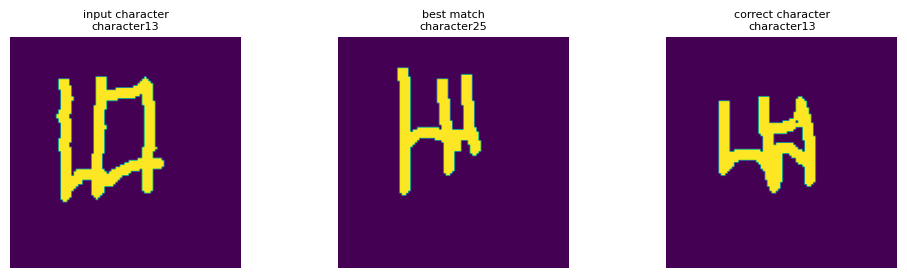

In [213]:
def display_random_match(model, data_dict_test, data_transform):
    alphabets_test = list(data_dict_test['annotated_images'].keys())
    alphabet_id = np.random.randint(0, len(alphabets_test))
    alphabet = alphabets_test[alphabet_id]

    alphabet_annotated = data_dict_test['annotated_images'][alphabet]
    alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]
    alphabet_unseen = data_dict_test['unseen_images'][alphabet]
    alphabet_unseen_labels = data_dict_test['unseen_images_labels'][alphabet]

    character_id = np.random.randint(0, len(alphabet_unseen))
    unseen_image = alphabet_unseen[character_id][0]
    unseen_label = alphabet_unseen_labels[character_id]

    matcher = CharacterMatcher(model, data_transform)
    matcher.fit(alphabet_annotated, alphabet_annotated_labels)

    matches = matcher.get_matches(unseen_image, k=1)

    alphabet_labels_to_idx = {k: v for v, k in enumerate(alphabet_annotated_labels)}

    matched_image = alphabet_annotated[alphabet_labels_to_idx[matches[0]]][0]
    correct_image = alphabet_annotated[alphabet_labels_to_idx[unseen_label]][0]

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))

    axs[0].imshow(unseen_image)
    axs[0].set_title("input character" + '\n' + unseen_label, fontsize=8)
    axs[0].axis('off')

    axs[1].imshow(matched_image)
    axs[1].set_title("best match" + '\n' + matches[0], fontsize=8)
    axs[1].axis('off')

    axs[2].imshow(correct_image)
    axs[2].set_title("correct character" + '\n' + unseen_label, fontsize=8)
    axs[2].axis('off')

display_random_match(model1, data_dict_test_task1, DATA_TRANSFORM_TASK1)

# Task 2: rotation problem

In [ ]:
# Model for bigger images
class EmbeddingNet_Task2(nn.Module):
    def __init__(self, embedding_size=40):
        """CNN Builder."""
        super(EmbeddingNet_Task2, self).__init__()

        self.embedding_size = embedding_size

        self.front_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Lambda(lambda x: x.view(x.size(0), -1)),

            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        self.last_layer = nn.Linear(512, self.embedding_size)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

In [ ]:
# load the test data for task 2:
# the structure of the test data of task 2 is exactly the same as for task 1,
# but now the images are rotated by an unknown angle between 0 and 360 degrees.
data_dict_test_task2 = load_data('data/a1/test_data_task2.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'data/a1/test_data_task2.pkl'

In [ ]:
# solution and evaluation of task 2:
import torchvision.transforms as transforms
rotation_transform = transforms.RandomRotation(degrees=(-10, 10))

In [ ]:
train_data_task2 = train_data.copy()

def transform_train_data(data_dict):
  for alphabet, characters in data_dict.items():
    for char, images in characters.items():
      augmented_images = []
      for image in images:
        augmented_image = rotation_transform(image)
        augmented_images.append(augmented_image)
        data_dict[alphabet][char] = augmented_images
  return data_dict

In [ ]:
transformed_train_data_task2 = transform_train_data(train_data_task2)

torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
torch.Size([1, 105, 105])


<Figure size 640x480 with 0 Axes>

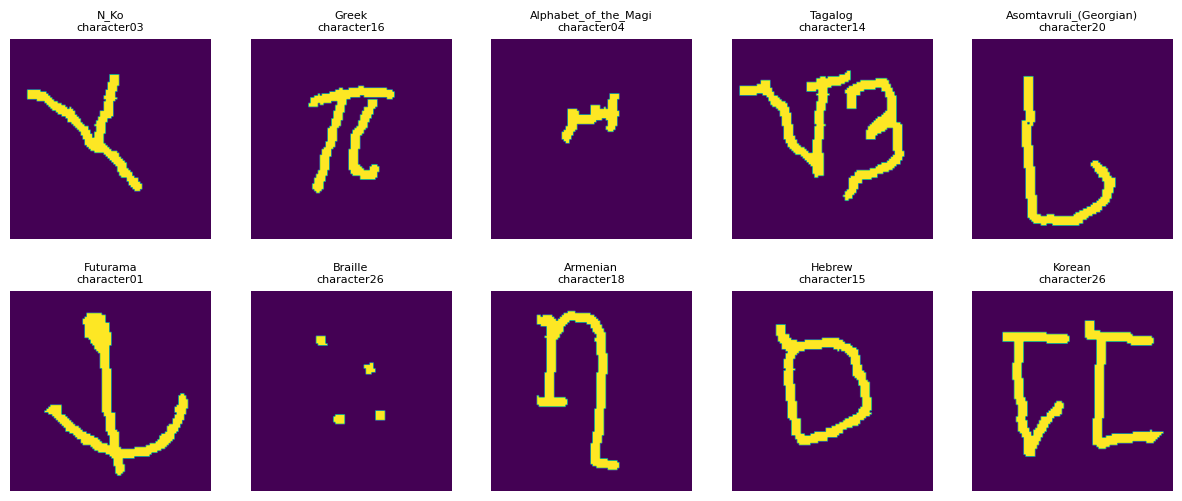

In [ ]:
plt.figure()
plot_example_data(transformed_train_data_task2)
# plt.savefig('example_data.png', dpi=600)
plt.show()

In [ ]:
#We follow the same steps as in our preprocessing of the first model to train "model2"

df_tobe = []
for alphabet in train_data_task2.keys():
    for key in train_data_task2[alphabet].keys():
        for image in train_data_task2[alphabet][key]:
            df_tobe.append((alphabet + '_' + key, image))
train_data_df_task2 = pd.DataFrame(data=df_tobe)

# random seed
random_seed = 42

from sklearn.model_selection import train_test_split
# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    train_data_df[1],
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    train_data_df[0],
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

label_to_idx_train = {k: v for v, k in enumerate(train_data_df[0].unique())}
idx_to_label_train = {v: k for v, k in enumerate(train_data_df[0].unique())}

inputs_train = inputs_train.values
inputs_valid = inputs_valid.values

targets_train = np.array([label_to_idx_train[label] for label in targets_train])
targets_valid = np.array([label_to_idx_train[label] for label in targets_valid])

image_size_task2 = (64,64)

DATA_TRANSFORM_TASK2 = transforms.Compose([
    transforms.Resize(image_size_task2),
    transforms.RandomRotation(180)
    # transforms.ToTensor(),
    ])

train_dataset_task2 = CustomImageDataset(inputs=inputs_train.copy(), targets=targets_train.copy(), transform=DATA_TRANSFORM_TASK2)
val_dataset_task2 = CustomImageDataset(inputs=inputs_valid.copy(), targets=targets_valid.copy(), transform=DATA_TRANSFORM_TASK2)

train_batch_sampler_task2 = BalancedBatchSampler(train_dataset_task2.targets, n_classes=20, n_samples=5)
test_batch_sampler_task2 = BalancedBatchSampler(val_dataset_task2.targets, n_classes=20, n_samples=5)

triplets_train_loader_task2 = torch.utils.data.DataLoader(train_dataset_task2, batch_sampler=train_batch_sampler_task2)
triplets_val_loader_task2 = torch.utils.data.DataLoader(val_dataset_task2, batch_sampler=test_batch_sampler_task2)

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

# model
embedding_net = EmbeddingNet_Task2()
model2 = embedding_net.to(device)


# margin value
margin=1

# criterion
criterion = TripletLoss(margin,  RandomTripletSelector())

# optimizer
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

# trainer
trainer = Trainer(model=model2,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader_task2,
                  validation_DataLoader=triplets_val_loader_task2,
                  epochs=20)

# start training
trainer.run_trainer()

  5%|▌         | 1/20 [00:17<05:40, 17.91s/it]

EPOCH: 01/20 LOSS: 0.6774 VAL-LOSS: 0.4565


 10%|█         | 2/20 [00:34<05:07, 17.06s/it]

EPOCH: 02/20 LOSS: 0.4343 VAL-LOSS: 0.4445


 15%|█▌        | 3/20 [00:50<04:45, 16.79s/it]

EPOCH: 03/20 LOSS: 0.3907 VAL-LOSS: 0.3391


 20%|██        | 4/20 [01:07<04:27, 16.73s/it]

EPOCH: 04/20 LOSS: 0.3280 VAL-LOSS: 0.3251


 25%|██▌       | 5/20 [01:24<04:15, 17.01s/it]

EPOCH: 05/20 LOSS: 0.3099 VAL-LOSS: 0.2933


 30%|███       | 6/20 [01:41<03:56, 16.91s/it]

EPOCH: 06/20 LOSS: 0.2762 VAL-LOSS: 0.3116


 35%|███▌      | 7/20 [01:59<03:42, 17.13s/it]

EPOCH: 07/20 LOSS: 0.2784 VAL-LOSS: 0.2506


 40%|████      | 8/20 [02:15<03:23, 16.97s/it]

EPOCH: 08/20 LOSS: 0.2836 VAL-LOSS: 0.2565


 45%|████▌     | 9/20 [02:32<03:06, 16.97s/it]

EPOCH: 09/20 LOSS: 0.2535 VAL-LOSS: 0.2658


 50%|█████     | 10/20 [02:49<02:49, 16.97s/it]

EPOCH: 10/20 LOSS: 0.2377 VAL-LOSS: 0.2499


 55%|█████▌    | 11/20 [03:06<02:30, 16.75s/it]

EPOCH: 11/20 LOSS: 0.2108 VAL-LOSS: 0.1981


 60%|██████    | 12/20 [03:22<02:12, 16.59s/it]

EPOCH: 12/20 LOSS: 0.2153 VAL-LOSS: 0.1805


 65%|██████▌   | 13/20 [03:39<01:56, 16.62s/it]

EPOCH: 13/20 LOSS: 0.1825 VAL-LOSS: 0.1786


 70%|███████   | 14/20 [03:56<01:41, 16.86s/it]

EPOCH: 14/20 LOSS: 0.1687 VAL-LOSS: 0.1787


 75%|███████▌  | 15/20 [04:12<01:23, 16.71s/it]

EPOCH: 15/20 LOSS: 0.1702 VAL-LOSS: 0.1851


 80%|████████  | 16/20 [04:28<01:06, 16.54s/it]

EPOCH: 16/20 LOSS: 0.1635 VAL-LOSS: 0.1906


 85%|████████▌ | 17/20 [04:45<00:49, 16.45s/it]

EPOCH: 17/20 LOSS: 0.1595 VAL-LOSS: 0.1639


 90%|█████████ | 18/20 [05:01<00:32, 16.43s/it]

EPOCH: 18/20 LOSS: 0.1486 VAL-LOSS: 0.1641


 95%|█████████▌| 19/20 [05:18<00:16, 16.72s/it]

EPOCH: 19/20 LOSS: 0.1499 VAL-LOSS: 0.1736


100%|██████████| 20/20 [05:35<00:00, 16.77s/it]

EPOCH: 20/20 LOSS: 0.1496 VAL-LOSS: 0.1400


In [ ]:
torch.save(model2.state_dict(), 'a1_model2.pt')

In [ ]:
model2 = EmbeddingNet_Task2()
model2.load_state_dict(torch.load('a1_model2.pt'))
#model1.eval()

<All keys matched successfully>

In [ ]:
#Evaluation

#At the moment the accuracy of the second model is ~25% (even lower than trained on unrotated (train) data, tested on rotated (test 2) data)

accuracy = get_accuracy(model1, data_dict_test_task2, k=8, transform=DATA_TRANSFORM_TASK1)
accuracy2 = get_accuracy(model2, data_dict_test_task2, k=8, transform=DATA_TRANSFORM_TASK2)
print("total accuracy (using model 1):", round(accuracy, 4))
print("total accuracy (using model 2):", round(accuracy2, 4))

100%|██████████| 20/20 [00:36<00:00,  1.83s/it]

total accuracy (using model 1): 0.4713
total accuracy (using model 2): 0.7779


# Task 3: Domain knowledge injection

In [ ]:
# load the test data for task 3:
# the structure of the data of task 3 is exactly the same as for task 1, but now our the loaded dictionary contains some additional keys.
# These additional keys will be explained in the cells below:

# data_dict_test_task3 = load_data('data/a1/test_data_task3.pkl')
data_dict_test_task3 = load_data('drive/MyDrive/GoogleColab/2AMM10/data_A1_2AMM10_2023_2024/test_data_task3.pkl')
print(data_dict_test_task3.keys())

dict_keys(['unseen_images_labels', 'annotated_images_labels', 'unseen_images', 'annotated_images', 'unseen_images_preceding_types', 'character_to_type_mapping', 'type_following_probs'])


In [ ]:
# The keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels' are the same as for task 1, and the structure of the data is exactly the same.

# The key 'unseen_images_preceding_types' maps to the type of the preceding character in the sequence where the unseen image was observed, for each alphabet.
# The key 'character_to_type_mapping' maps to the mapping of each character to its type, for each alphabet.
# The key 'type_following_probs' maps to the probabilities of each character type being followed by another character type, for each alphabet.

In [ ]:
# examples:

alphabet = np.random.choice(list(data_dict_test_task3['unseen_images_preceding_types'].keys()))
print(f'Alphabet: {alphabet}')


preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]  # a list
print(f'Some character types that preceded unseen images from the {alphabet} alphabet: {np.random.choice(preceding_character_types_alphabet, size=5)}')
print(f'There are {len(preceding_character_types_alphabet)} preceding character types in the {alphabet} alphabet, and {len(data_dict_test_task3["unseen_images"][alphabet])} unseen images.')


character_to_type_mapping_alphabet = data_dict_test_task3["character_to_type_mapping"][alphabet]
# this is a dict, with as keys the characters and as values the types
random_character = np.random.choice(list(character_to_type_mapping_alphabet.keys()))
print(f'Type of {random_character} from the {alphabet} alphabet: {character_to_type_mapping_alphabet[random_character]}')


type_following_probs_alphabet = data_dict_test_task3["type_following_probs"][alphabet]  # a dict of dicts
preceding_type = np.random.choice(list(type_following_probs_alphabet.keys()))
following_type = np.random.choice(list(type_following_probs_alphabet[preceding_type].keys()))
print(f'Probability of a character of type {following_type} following a character of type {preceding_type} in the {alphabet} alphabet: {type_following_probs_alphabet[preceding_type][following_type]}')


Alphabet: Glagolitic
Some character types that preceded unseen images from the Glagolitic alphabet: ['I' 'II' 'II' 'I' 'I']
There are 855 preceding character types in the Glagolitic alphabet, and 855 unseen images.
Type of character18 from the Glagolitic alphabet: II
Probability of a character of type I following a character of type I in the Glagolitic alphabet: 0.057692307692307696


In [ ]:
preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]
preceding_character_types_alphabet

['II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'I',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'I',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'I',
 'II',
 'II',
 'I',
 'II',
 'I',
 'I',
 'II',
 'I',
 'I',
 'II',
 'I',
 'II',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'I',
 'I',
 'II',
 'I',
 'II',
 'II',
 'I',
 'I',
 'I',
 'I',
 'I',
 'I',
 'II',
 'I',
 'I',
 'I',
 'II',
 'I',
 'I',
 'II',
 'I',
 'I',
 'I',
 'II',
 'II',
 'I',
 'I',
 'II',
 'II',
 'II',
 'I',
 'II',
 'I',
 'I',
 'II',
 'I',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 'II',
 '

In [ ]:
x = 0.35
accuracy_with = get_accuracy(model1, data_dict_test_task3, k=1, transform=DATA_TRANSFORM_TASK1, use_domain_knowledge=True, domain_knowledge_factor=x)
print(f"with factor {x}:", accuracy_with)

100%|██████████| 20/20 [00:32<00:00,  1.62s/it]

with factor 0.35: 0.5106620876926763


In [ ]:
accuracy_with = get_accuracy(model1, data_dict_test_task3, k=8, transform=DATA_TRANSFORM_TASK1, use_domain_knowledge=True, domain_knowledge_factor=0.3)
print(accuracy_with)
accuracy_without = get_accuracy(model1, data_dict_test_task3, k=8, transform=DATA_TRANSFORM_TASK1)
print(accuracy_without)

100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


0.911428799616644


100%|██████████| 20/20 [00:31<00:00,  1.56s/it]

0.9059180576631259
